In [1]:
'''
Description:
    Loads precomputed curvature scores from calc_curv_fz_imagenet_models.py
    on Feldman and Zhang[1] ResNet50 models for ratio 0.7 [2] and averages over 100 models
    to generate curvature vs memorization graph

Reference:
[1] Feldman, V. and Zhang, C. What neural networks memorize and why: Discovering the long tail via influence estimation. 
Advances in Neural Information Processing Systems, 33:2881-2891, 2020.
[2] Feldman, V. and Zhang, C. project website https://pluskid.github.io/influence-memorization/
'''
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Specify the path to the config JSON file
json_file_path = 'config.json'

# Open and read the JSON file
with open(json_file_path, 'r') as json_file:
    # Load the JSON data into a Python dictionary
    config = json.load(json_file)

h = 1e-3
dataset = 'imagenet'
save_mem_dir = config['fz_precomputed_score_dir'][dataset.lower()]
fz_model_root_dir = config['fz_model_dir'][dataset.lower()]

scores_curv = []
masks = []
correctness = []
for ratio in ["0.7"]:
    for exp_idx in range(100):
        # Missed these two seeds
        if exp_idx in [46, 47]:
            continue

        model_name = f"{dataset.lower()}_resnet50_{ratio}_{exp_idx}"
        directory_path = os.path.join(save_mem_dir, model_name)
        scores_file_name = f"curv_scores_{model_name}_{h}.pt"
        labels_file_name = f"true_labels_{model_name}_{h}.pt"
        scores = torch.load(os.path.join(directory_path, scores_file_name))
        labels = torch.load(os.path.join(directory_path, labels_file_name))
        
        array = np.load(os.path.join(fz_model_root_dir, str(ratio), str(exp_idx), "aux_arrays.npz"), allow_pickle=True)
        subset_idx = array["index_train"]

        scores_curv.append(scores.numpy())
        mask = np.zeros(len(scores))
        correct = np.ones_like(mask) * -1
        removed_idx = array['index_removed']
        correct[removed_idx] = array['correctness_removed'].astype(correct.dtype)
        mask[subset_idx] = 1
        masks.append(mask)
        correctness.append(correct)

    scores_curv = np.row_stack(scores_curv)
    masks = np.row_stack(masks)
    correctness = np.row_stack(correctness)

    avg_score = (scores_curv * masks).max(0)

In [2]:
avg_score = (scores_curv * masks).max(0)
correct_rem = (correctness * (1-masks))
acc = correct_rem.sum(0) / (1-masks).sum(0)

# This is the file from Feldman and Zhang[1] see first code block for reference
npz = np.load('./analysis_checkpoints/imagenet/imagenet_index.npz', allow_pickle=True)
fz_scores = pd.DataFrame.from_dict({item: npz[item] for item in ['tr_filenames', 'tr_labels', 'tr_mem']})
df = pd.DataFrame(data={''})

fz_scores['tr_curv'] = avg_score
fz_scores['acc'] = acc
bin_width = 0.02
fz_avg = []
curv_avg = []
curv_error = []
acc = []
counts = []
for bin_start in np.arange(0, 1, step=bin_width):
    in_bin = np.logical_and(fz_scores['tr_mem'].to_numpy() >= bin_start, fz_scores['tr_mem'].to_numpy() < (bin_start + bin_width))
    idxs_4_bin = np.where(in_bin)
    bin_scores = fz_scores.iloc[idxs_4_bin]
    bin_acc = bin_scores['acc'].mean() * 100
    fz_avg.append(bin_scores['tr_mem'].mean())
    len_subpop = len(bin_scores)
    curv_avg.append(bin_scores['tr_curv'].mean())
    curv_error.append(bin_scores['tr_curv'].std())
    acc.append(bin_acc)
    counts.append(len(bin_scores))


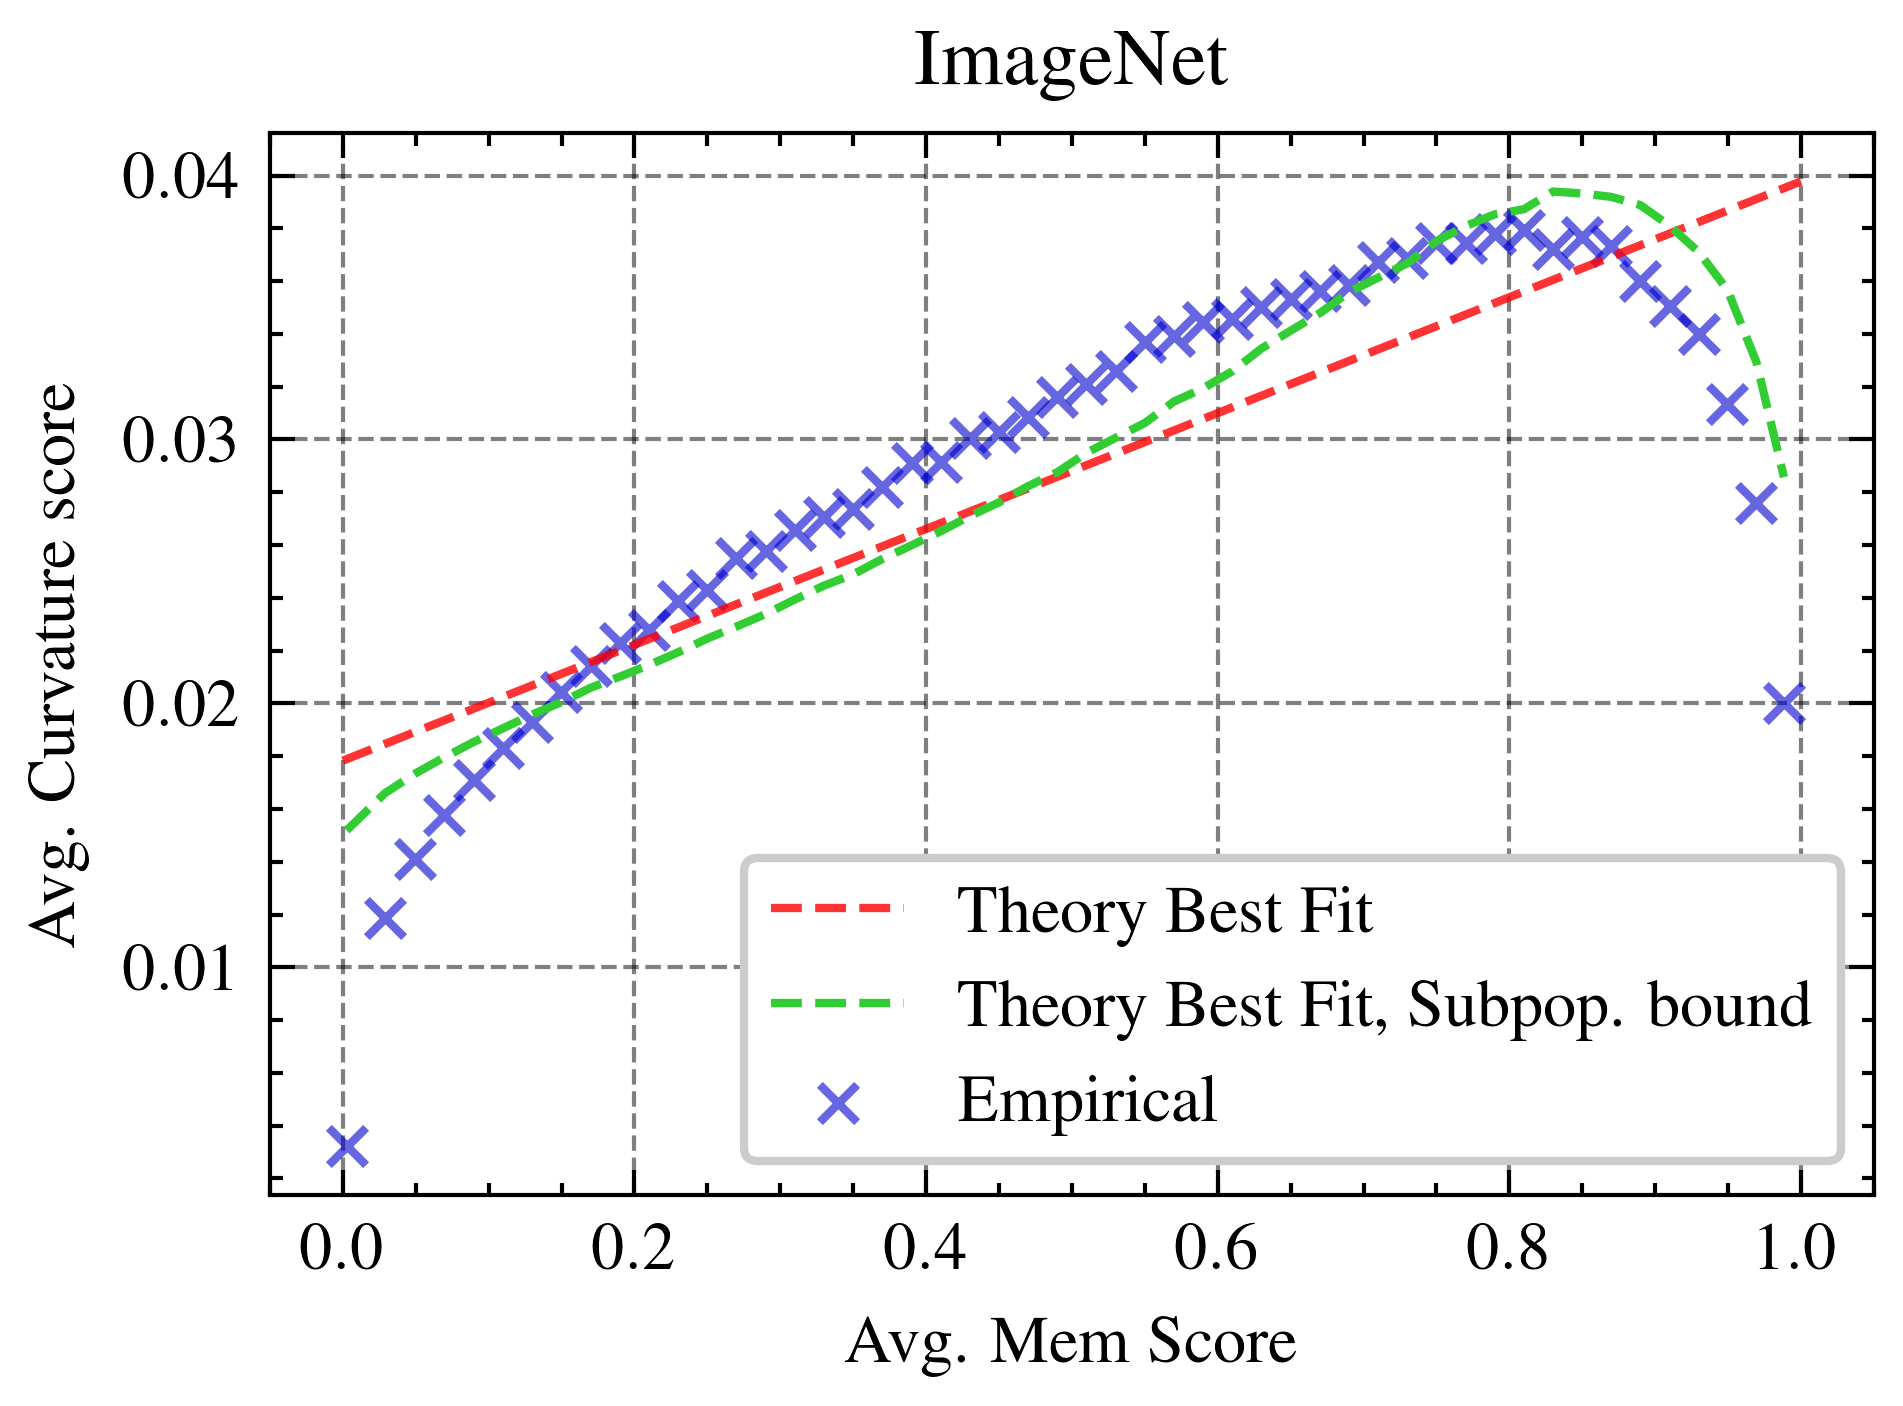

In [3]:
# Plot best fit model from theory

from sklearn.linear_model import LinearRegression
import scienceplots
plt.style.use(['ieee','science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))

lin_model = LinearRegression(positive=True)
tr_x = np.array(fz_avg)
tr_x2 = np.sqrt(np.array(counts))
tr_x3 = 100 - np.array(acc)
tr_y = np.array(curv_avg)
X = np.column_stack([tr_x * tr_x2])
theta = np.polyfit(tr_x, tr_y, 1)
lin_model.fit(X, tr_y)
plot_x = np.linspace(0, 1, 100)
y_line = theta[1] + theta[0] * plot_x

plt.plot(plot_x, y_line, linestyle='dashed', label=f'Theory Best Fit', c='r', alpha=0.8)
plt.plot(tr_x, lin_model.predict(X), linestyle='dashed', label=f'Theory Best Fit, Subpop. bound', c= 'limegreen')
plt.scatter(fz_avg, curv_avg, c='mediumblue', label="Empirical", alpha=0.6, s=20, marker='x')
ax = plt.gca()
plt.xlabel('Avg. Mem Score')
ax.set_ylabel('Avg. Curvature score')
plt.title('ImageNet')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("./images/fz_avg_curv_vs_mem_imagenet.png")